# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Предложена идея определять возраст клиентов по их фотографии, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Попробуем построить модель, которая будет предсказывать возраст: нам предоставлен датасет фотографий людей с указанием их реального возраста.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

Выгрузим данные

In [2]:
%%time
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.
CPU times: user 432 ms, sys: 343 ms, total: 774 ms
Wall time: 1min 24s


In [3]:
labels.info()
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Нам предоставлен 7591 файл с фотографиями людей, пропусков нет.

Посмотрим на распределение по возрасту.

In [4]:
labels.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


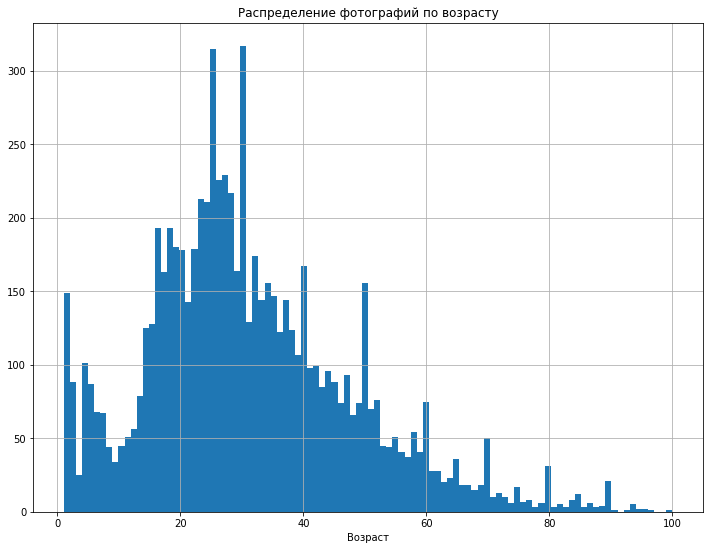

In [5]:
labels['real_age'].hist(bins=100, figsize=(12, 9))
plt.title('Распределение фотографий по возрасту')
plt.xlabel('Возраст')
plt.show()

Видим, что возраст людей на фото варьируется от 1 года до 100. Из гистограммы видим, что представлены почти все возраста, но в интервале 90-100 лет есть пропуски и данных мало.

Посмотрим на предоставленные нам фотографии

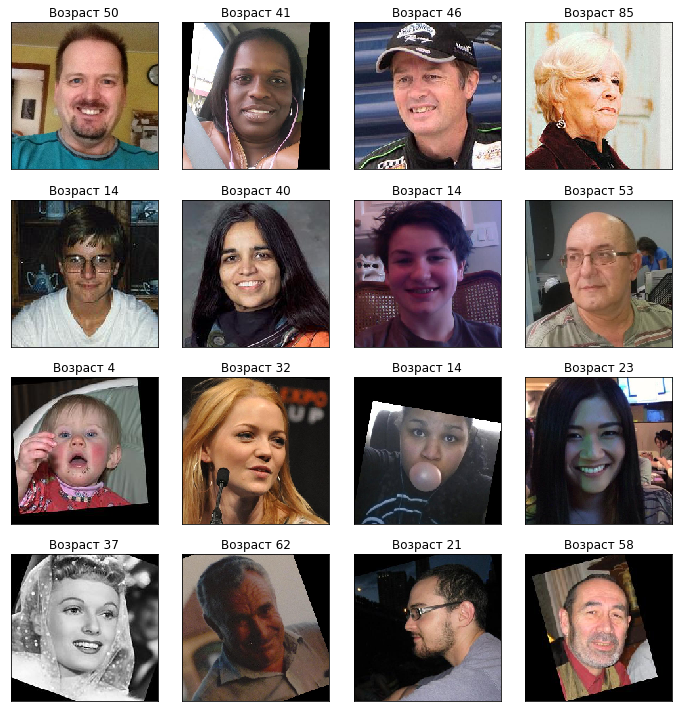

In [6]:
photos, ages = next(train_gen_flow)
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(photos[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(f'Возраст {ages[i]}') 

Качество фотографий разное, есть как цветные, так и черно-белые. С некоторыми фотографиями уже проведена аументация: встречаются фото с поворотами и сдвигами. Представлены различные эмоции и разные ракурсы.

Будем строить сеть с архитектурой ResNet с весами ImageNet, костяк замораживать не будем. В качестве метрики попробуем MAE, т.к. она хорошо интерпретируется. В последнем слое используем активацию RELU, чтобы избежать отрицательных предсказаний.

## Обучение модели

Код в этом разделе запускался в отдельном GPU-тренажёре.

```python
import numpy as np
import pandas as pd

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Nadam

# подготовка загрузчика обучающей выборки    
def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')   
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                        validation_split=0.25,
                                        rotation_range=20,                                        
                                        horizontal_flip=True)
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
        
    return train_datagen_flow

# подготовка загрузчика тестовой выборки
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
        
    return test_datagen_flow

# подготовка модели
def create_model(input_shape):
    path_to_weights = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
    backbone = ResNet50(input_shape=input_shape, 
                        weights=path_to_weights, 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae'])

    return model

# обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
               steps_per_epoch=None, validation_steps=None):   
               
    if steps_per_epoch == None:
        steps_per_epoch = len(train_data)
    if validation_steps == None:
        validation_steps = len(test_data)
    
    model.fit(train_data, 
              validation_data=(test_data),
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    
    return model
```

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
2021-09-11 20:12:18.646150: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-09-11 20:12:22.632542: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 158s - loss: 440.7695 - mae: 15.4118 - val_loss: 287.3700 - val_mae: 13.0468
Epoch 2/20
178/178 - 58s - loss: 107.4649 - mae: 7.7523 - val_loss: 678.5190 - val_mae: 21.0611
Epoch 3/20
178/178 - 57s - loss: 78.9109 - mae: 6.7602 - val_loss: 598.0316 - val_mae: 19.3112
Epoch 4/20
178/178 - 57s - loss: 61.2244 - mae: 5.9489 - val_loss: 132.3502 - val_mae: 8.5476
Epoch 5/20
178/178 - 58s - loss: 49.0726 - mae: 5.3492 - val_loss: 89.6906 - val_mae: 7.2008
Epoch 6/20
178/178 - 58s - loss: 41.5112 - mae: 4.9470 - val_loss: 77.1775 - val_mae: 6.6311
Epoch 7/20
178/178 - 58s - loss: 35.5928 - mae: 4.5612 - val_loss: 78.7008 - val_mae: 6.6882
Epoch 8/20
178/178 - 57s - loss: 31.1512 - mae: 4.2876 - val_loss: 74.2859 - val_mae: 6.4685
Epoch 9/20
178/178 - 58s - loss: 26.8343 - mae: 3.9882 - val_loss: 72.3577 - val_mae: 6.4832
Epoch 10/20
178/178 - 58s - loss: 23.6069 - mae: 3.7450 - val_loss: 69.7609 - val_mae: 6.3464
Epoch 11/20
178/178 - 57s - loss: 21.8782 - mae: 3.5813 - val_loss: 74.7551 - val_mae: 6.5819
Epoch 12/20
178/178 - 58s - loss: 19.4426 - mae: 3.3817 - val_loss: 72.3905 - val_mae: 6.3947
Epoch 13/20
178/178 - 58s - loss: 16.3784 - mae: 3.0872 - val_loss: 73.0267 - val_mae: 6.5226
Epoch 14/20
178/178 - 58s - loss: 15.2453 - mae: 2.9941 - val_loss: 78.6816 - val_mae: 6.5565
Epoch 15/20
178/178 - 58s - loss: 13.5498 - mae: 2.8080 - val_loss: 70.9848 - val_mae: 6.3145
Epoch 16/20
178/178 - 58s - loss: 12.5513 - mae: 2.7042 - val_loss: 84.0617 - val_mae: 6.7860
Epoch 17/20
178/178 - 58s - loss: 11.4940 - mae: 2.5697 - val_loss: 69.1818 - val_mae: 6.2807
Epoch 18/20
178/178 - 58s - loss: 11.1199 - mae: 2.5367 - val_loss: 71.3647 - val_mae: 6.3843
Epoch 19/20
178/178 - 58s - loss: 10.6417 - mae: 2.4874 - val_loss: 67.3476 - val_mae: 6.1867
Epoch 20/20
178/178 - 57s - loss: 9.3959 - mae: 2.3350 - val_loss: 65.4114 - val_mae: 6.0729
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 65.4114 - mae: 6.0729
Test MAE: 6.0729
```

Повторные запуски модели показали, что MAE $= 6.24 \pm 0.11$.

## Анализ обученной модели

Видим, что модель переобучена: значение метрики на обучающей выборки заметно меньше значения на тестовой. Это свойственно нейронным сетям с большим количеством слоев. 

Тем не менее настройка модели позволила достичь значения MAE на тестовой выборке около 6.2. Это значит, что при оценке возраста мы в среднем ошибаемся чуть больше, чем на 6 лет. 

С учетом такой погрешности можно попробовать использовать модель для рекомендации товаров в прикассовой зоне. Возможно, стоит попробовать добавить определение пола для более точных рекомендаций.

А вот для контроля добросовестности кассиров при продаже алкоголя модель с такой погрешностью предсказания не подходит. Для этой цели стоит попробовать построить модель классификации, которая будет разделять покупателей на группы старше 18 и младше 18 лет.